In [1]:
import datetime
import pickle
import polars as pl
import ml_utils
import mlflow
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error
import constants
import numpy as np
import optuna
from optuna.integration.mlflow import MLflowCallback

In [2]:
with open("df_all.pkl", "rb") as file:
    df_all = pickle.load(file)

In [3]:
df_all = df_all.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

df_all.head(8)

date,a,b,o,ab,all,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,weekday,month,day_of_year
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,i8,i8,i16
2006-01-01,152,139,194,40,525,0,0,0,0,7,1,1
2006-01-02,53,43,112,19,227,0,0,0,0,1,1,2
2006-01-03,29,21,56,6,112,0,0,0,0,2,1,3
2006-01-04,92,98,165,36,391,0,0,0,0,3,1,4
2006-01-05,149,198,193,42,582,0,0,0,0,4,1,5
2006-01-06,94,77,126,27,324,0,0,0,0,5,1,6
2006-01-07,29,28,48,13,118,0,0,0,0,6,1,7
2006-01-08,218,212,314,51,795,0,0,0,0,7,1,8


In [4]:
for lag in range(1, constants.WINDOW_SIZE+1):
    df_all = df_all.with_columns(
        pl.col("all").shift(lag).alias(f"all_lag_{lag}")
    )

df_all = df_all.drop_nulls()

In [5]:
df_all

date,a,b,o,ab,all,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,weekday,month,day_of_year,all_lag_1,all_lag_2,all_lag_3,all_lag_4,all_lag_5,all_lag_6,all_lag_7
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,i8,i8,i16,i64,i64,i64,i64,i64,i64,i64
2006-01-08,218,212,314,51,795,0,0,0,0,7,1,8,118,324,582,391,112,227,525
2006-01-09,83,95,151,17,346,0,0,0,0,1,1,9,795,118,324,582,391,112,227
2006-01-10,1,0,1,0,2,0,0,1,0,2,1,10,346,795,118,324,582,391,112
2006-01-11,128,111,179,30,448,0,0,0,0,3,1,11,2,346,795,118,324,582,391
2006-01-12,211,236,316,42,805,0,0,0,0,4,1,12,448,2,346,795,118,324,582
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-06-01,556,589,1056,65,2266,0,0,0,0,7,6,152,1600,946,1379,1439,1181,1024,3215
2025-06-02,442,509,781,60,1792,0,1,0,0,1,6,153,2266,1600,946,1379,1439,1181,1024
2025-06-03,282,293,460,49,1084,0,0,0,0,2,6,154,1792,2266,1600,946,1379,1439,1181


In [6]:
X_seq = df_all.select([f"all_lag_{lag}" for lag in range(1, constants.WINDOW_SIZE+1)]).to_numpy().reshape(-1, constants.WINDOW_SIZE, 1)
X_features = df_all.select(["weekday", "month", "day_of_year", "is_religion_or_culture_holiday", "is_other_holiday", "is_low_donation_holiday", "is_high_donation_holiday"]).to_numpy()
y = df_all['all'].to_numpy()

In [7]:
# Set up scalers 
from sklearn.preprocessing import RobustScaler

y_scaler = RobustScaler()
X_scaler = RobustScaler()

In [8]:
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
X_features_scaled = X_scaler.fit_transform(X_features)
X_seq_scaled = y_scaler.transform(X_seq.reshape(-1, 1)).reshape(-1, constants.WINDOW_SIZE, 1)

In [9]:
with open('shared/x_scaler.pkl', 'wb') as file:
    pickle.dump(X_scaler, file)
    
with open('shared/y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)

In [10]:
X_seq_train, X_seq_val, X_seq_test, X_features_train, X_features_val, X_features_test, y_train, y_val, y_test = ml_utils.train_val_split_lstm_feature_data(
    X_seq_scaled,
    X_features_scaled,
    y_scaled,
    constants.TRAIN_FRAC,
    constants.VAL_FRAC
)

In [ ]:
experiment_name = f"{constants.EXPERIMENT_NAME}_{datetime.datetime.now().strftime('%Y%m%d')}"
experiment_id = ml_utils.get_or_create_mlflow_experiment(experiment_name)
mlflow.set_experiment(experiment_name)
mlflow_callback = MLflowCallback(
    tracking_uri = mlflow.get_tracking_uri(),
    metric_name = "val_loss"
)

In [12]:
def objective(trial):
    seq_type = trial.suggest_categorical("seq_type", ["LSTM", "SimpleRNN", "GRU"])
    seq_units = trial.suggest_int("seq_units", 12, 48)
    dense_units = trial.suggest_int("dense_units", 4, 12)
    activation = trial.suggest_categorical("activation", ["tanh", "relu", "mish"])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    dropout = trial.suggest_float("dropout", 0.01, 0.1)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)  # log scale for LR
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    ml_utils.run_experiment(
        X_seq_train, X_features_train, y_train,
        X_seq_val, X_features_val, y_val,
        seq_type=seq_type,
        seq_units=seq_units,
        dense_units=dense_units,
        activation=activation,
        optimizer=optimizer,
        dropout=dropout,
        learning_rate=learning_rate,
        batch_size=batch_size,
        experiment_id=experiment_id
    )
    
    runs = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["start_time DESC"])
    val_loss = runs.iloc[0]["metrics.val_loss"]
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=constants.N_TRIALS, callbacks=[mlflow_callback])

[I 2025-06-07 22:08:33,170] A new study created in memory with name: no-name-54b55d52-6eb9-41ab-b1d7-87a6b7749ae2


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1927 - mae: 0.3014 


[I 2025-06-07 22:09:24,765] Trial 0 finished with value: 0.20379522442817688 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 18, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.04959898795719846, 'learning_rate': 0.0008886258497792887, 'batch_size': 32}. Best is trial 0 with value: 0.20379522442817688.
2025/06/07 22:09:24 INFO mlflow.tracking.fluent: Experiment with name 'no-name-54b55d52-6eb9-41ab-b1d7-87a6b7749ae2' does not exist. Creating a new experiment.


Validation Loss: 0.20379522442817688, Validation MAE: 0.31474316120147705


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2320 - mae: 0.3353 


[I 2025-06-07 22:09:43,304] Trial 1 finished with value: 0.25953733921051025 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 43, 'dense_units': 4, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.053885902889609635, 'learning_rate': 0.06088444018097705, 'batch_size': 64}. Best is trial 0 with value: 0.20379522442817688.


Validation Loss: 0.25953730940818787, Validation MAE: 0.35696834325790405


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1935 - mae: 0.3024 


[I 2025-06-07 22:10:18,324] Trial 2 finished with value: 0.20677542686462402 and parameters: {'seq_type': 'GRU', 'seq_units': 48, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.07378638763505532, 'learning_rate': 0.0012722642461827749, 'batch_size': 64}. Best is trial 0 with value: 0.20379522442817688.


Validation Loss: 0.20677542686462402, Validation MAE: 0.3126206398010254


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1900 - mae: 0.2968 
Validation Loss: 0.20400069653987885, Validation MAE: 0.31370237469673157


[I 2025-06-07 22:10:43,223] Trial 3 finished with value: 0.20400069653987885 and parameters: {'seq_type': 'GRU', 'seq_units': 13, 'dense_units': 9, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.08139677442192828, 'learning_rate': 0.0029663365365118375, 'batch_size': 32}. Best is trial 0 with value: 0.20379522442817688.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1847 - mae: 0.3062 


[I 2025-06-07 22:11:26,517] Trial 4 finished with value: 0.192522794008255 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 25, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.060462180267664506, 'learning_rate': 0.018292833040344837, 'batch_size': 32}. Best is trial 4 with value: 0.192522794008255.


Validation Loss: 0.192522794008255, Validation MAE: 0.3149639070034027


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2016 - mae: 0.3056 


[I 2025-06-07 22:14:51,194] Trial 5 finished with value: 0.21492642164230347 and parameters: {'seq_type': 'LSTM', 'seq_units': 39, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.03123838921895912, 'learning_rate': 0.00010813403644974771, 'batch_size': 32}. Best is trial 4 with value: 0.192522794008255.


Validation Loss: 0.21492642164230347, Validation MAE: 0.3204945921897888


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2064 - mae: 0.3057 


[I 2025-06-07 22:15:15,492] Trial 6 finished with value: 0.2214582860469818 and parameters: {'seq_type': 'GRU', 'seq_units': 31, 'dense_units': 6, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.07255184206728231, 'learning_rate': 0.014220373200181392, 'batch_size': 128}. Best is trial 4 with value: 0.192522794008255.


Validation Loss: 0.2214582860469818, Validation MAE: 0.3229002058506012


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1896 - mae: 0.3052 


[I 2025-06-07 22:15:49,229] Trial 7 finished with value: 0.20231197774410248 and parameters: {'seq_type': 'LSTM', 'seq_units': 23, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.021449173484571114, 'learning_rate': 0.004989398595717874, 'batch_size': 64}. Best is trial 4 with value: 0.192522794008255.


Validation Loss: 0.20231199264526367, Validation MAE: 0.31348562240600586


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1952 - mae: 0.3176 


[I 2025-06-07 22:16:03,049] Trial 8 finished with value: 0.2198929488658905 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 21, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.05140627877674775, 'learning_rate': 0.031850341721737604, 'batch_size': 128}. Best is trial 4 with value: 0.192522794008255.


Validation Loss: 0.2198929637670517, Validation MAE: 0.33510562777519226


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2436 - mae: 0.3380 
Validation Loss: 0.2584839165210724, Validation MAE: 0.35755082964897156


[I 2025-06-07 22:16:17,520] Trial 9 finished with value: 0.25848397612571716 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 45, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.0336163461400161, 'learning_rate': 0.023400108111822943, 'batch_size': 128}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7218 - mae: 0.6543 
Validation Loss: 0.784411609172821, Validation MAE: 0.6798015236854553


[I 2025-06-07 22:16:38,501] Trial 10 finished with value: 0.784411609172821 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 32, 'dense_units': 4, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.0919278349605579, 'learning_rate': 0.080108470265243, 'batch_size': 32}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1921 - mae: 0.2965
Validation Loss: 0.20564278960227966, Validation MAE: 0.31329622864723206


[I 2025-06-07 22:16:59,331] Trial 11 finished with value: 0.20564278960227966 and parameters: {'seq_type': 'LSTM', 'seq_units': 25, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.011898628328732478, 'learning_rate': 0.0082345617369965, 'batch_size': 64}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2015 - mae: 0.3060
Validation Loss: 0.21226324141025543, Validation MAE: 0.31767916679382324


[I 2025-06-07 22:17:49,517] Trial 12 finished with value: 0.21226321160793304 and parameters: {'seq_type': 'LSTM', 'seq_units': 26, 'dense_units': 6, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.013806078411835388, 'learning_rate': 0.004875195882453402, 'batch_size': 64}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1898 - mae: 0.3000 
Validation Loss: 0.20313331484794617, Validation MAE: 0.31157612800598145


[I 2025-06-07 22:19:13,997] Trial 13 finished with value: 0.20313331484794617 and parameters: {'seq_type': 'LSTM', 'seq_units': 36, 'dense_units': 6, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.035291127133405584, 'learning_rate': 0.0019425848646292556, 'batch_size': 32}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1862 - mae: 0.2938
Validation Loss: 0.19667915999889374, Validation MAE: 0.3089284598827362


[I 2025-06-07 22:22:29,071] Trial 14 finished with value: 0.19667917490005493 and parameters: {'seq_type': 'LSTM', 'seq_units': 18, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.06450685643236878, 'learning_rate': 0.0003949916620300902, 'batch_size': 64}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2030 - mae: 0.3081
Validation Loss: 0.2226693481206894, Validation MAE: 0.32693955302238464


[I 2025-06-07 22:24:11,173] Trial 15 finished with value: 0.2226693481206894 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 12, 'dense_units': 12, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.0684400155811071, 'learning_rate': 0.00029495663979977525, 'batch_size': 64}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2047 - mae: 0.3033
Validation Loss: 0.21962839365005493, Validation MAE: 0.32344850897789


[I 2025-06-07 22:26:44,630] Trial 16 finished with value: 0.21962839365005493 and parameters: {'seq_type': 'LSTM', 'seq_units': 17, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.06194916840716711, 'learning_rate': 0.00034115648353626367, 'batch_size': 32}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1883 - mae: 0.2981
Validation Loss: 0.20099861919879913, Validation MAE: 0.3082858622074127


[I 2025-06-07 22:28:03,694] Trial 17 finished with value: 0.20099863409996033 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 29, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.09439227183027162, 'learning_rate': 0.0005378094104297285, 'batch_size': 64}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1850 - mae: 0.3027
Validation Loss: 0.19638825953006744, Validation MAE: 0.3141123354434967


[I 2025-06-07 22:33:47,360] Trial 18 finished with value: 0.19638825953006744 and parameters: {'seq_type': 'LSTM', 'seq_units': 21, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.04529555320037712, 'learning_rate': 0.0001457832268681329, 'batch_size': 32}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2157 - mae: 0.3056
Validation Loss: 0.23544010519981384, Validation MAE: 0.32677432894706726


[I 2025-06-07 22:42:36,322] Trial 19 finished with value: 0.23544010519981384 and parameters: {'seq_type': 'GRU', 'seq_units': 28, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.04104071280393945, 'learning_rate': 0.00012046116352456835, 'batch_size': 32}. Best is trial 4 with value: 0.192522794008255.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1661 - mae: 0.2913
Validation Loss: 0.18980711698532104, Validation MAE: 0.31361961364746094


[I 2025-06-07 22:44:14,884] Trial 20 finished with value: 0.18980711698532104 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 33, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.0468081779068412, 'learning_rate': 0.011543641554749793, 'batch_size': 32}. Best is trial 20 with value: 0.18980711698532104.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1739 - mae: 0.3001
Validation Loss: 0.18713775277137756, Validation MAE: 0.3131795823574066


[I 2025-06-07 22:45:26,759] Trial 21 finished with value: 0.18713775277137756 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 36, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.05874097481100644, 'learning_rate': 0.012214529973247417, 'batch_size': 32}. Best is trial 21 with value: 0.18713775277137756.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1670 - mae: 0.2841
Validation Loss: 0.18584194779396057, Validation MAE: 0.3061739504337311


[I 2025-06-07 22:49:41,935] Trial 22 finished with value: 0.18584194779396057 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 35, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.058433538381260204, 'learning_rate': 0.01232261330084442, 'batch_size': 32}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1907 - mae: 0.3008 
Validation Loss: 0.20406197011470795, Validation MAE: 0.3143034875392914


[I 2025-06-07 22:50:26,615] Trial 23 finished with value: 0.20406197011470795 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 35, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.08215929111077538, 'learning_rate': 0.01202969087856429, 'batch_size': 32}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1783 - mae: 0.2882
Validation Loss: 0.18954366445541382, Validation MAE: 0.29904016852378845


[I 2025-06-07 22:51:59,382] Trial 24 finished with value: 0.18954366445541382 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 39, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.05520599107391644, 'learning_rate': 0.007691747003951624, 'batch_size': 32}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2281 - mae: 0.3466
Validation Loss: 0.23223721981048584, Validation MAE: 0.36017805337905884


[I 2025-06-07 22:53:23,765] Trial 25 finished with value: 0.23223721981048584 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 40, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.05512766819134098, 'learning_rate': 0.03486332230291502, 'batch_size': 32}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1869 - mae: 0.2980
Validation Loss: 0.20002278685569763, Validation MAE: 0.3127060830593109


[I 2025-06-07 22:54:38,908] Trial 26 finished with value: 0.20002278685569763 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 38, 'dense_units': 9, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.05830609105391584, 'learning_rate': 0.005861880188206492, 'batch_size': 32}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2017 - mae: 0.3010
Validation Loss: 0.21588313579559326, Validation MAE: 0.3153814971446991


[I 2025-06-07 22:55:41,031] Trial 27 finished with value: 0.21588318049907684 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 42, 'dense_units': 6, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.07504792424015366, 'learning_rate': 0.0028014417301346147, 'batch_size': 128}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1815 - mae: 0.3001 
Validation Loss: 0.19524957239627838, Validation MAE: 0.3135351240634918


[I 2025-06-07 22:56:13,444] Trial 28 finished with value: 0.19524957239627838 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 36, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.04231488215967945, 'learning_rate': 0.007988721760578674, 'batch_size': 32}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1798 - mae: 0.2993
Validation Loss: 0.20612867176532745, Validation MAE: 0.3228834867477417


[I 2025-06-07 22:56:49,654] Trial 29 finished with value: 0.20612867176532745 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 34, 'dense_units': 9, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.0666215528817105, 'learning_rate': 0.03107065280868489, 'batch_size': 32}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2036 - mae: 0.3132
Validation Loss: 0.2156675159931183, Validation MAE: 0.3269653618335724


[I 2025-06-07 22:57:40,800] Trial 30 finished with value: 0.2156675159931183 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 45, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.05078433927974469, 'learning_rate': 0.0016305845331401312, 'batch_size': 32}. Best is trial 22 with value: 0.18584194779396057.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1652 - mae: 0.2856
Validation Loss: 0.18222002685070038, Validation MAE: 0.29977405071258545


[I 2025-06-07 22:58:38,291] Trial 31 finished with value: 0.18222002685070038 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 33, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.04683965538307314, 'learning_rate': 0.011102737363263504, 'batch_size': 32}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2277 - mae: 0.3400 
Validation Loss: 0.2564972937107086, Validation MAE: 0.363674134016037


[I 2025-06-07 22:59:11,400] Trial 32 finished with value: 0.2564972937107086 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 38, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.05609816585777771, 'learning_rate': 0.04819519779265446, 'batch_size': 32}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1913 - mae: 0.3033
Validation Loss: 0.20567312836647034, Validation MAE: 0.3193546533584595


[I 2025-06-07 22:59:46,418] Trial 33 finished with value: 0.20567312836647034 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 42, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.03744700932981527, 'learning_rate': 0.008508781999615207, 'batch_size': 32}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1775 - mae: 0.2867
Validation Loss: 0.19541415572166443, Validation MAE: 0.3017580211162567


[I 2025-06-07 23:00:37,881] Trial 34 finished with value: 0.19541415572166443 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 30, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.04916561486480128, 'learning_rate': 0.020398499378764, 'batch_size': 32}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1854 - mae: 0.2939
Validation Loss: 0.20103861391544342, Validation MAE: 0.3078998327255249


[I 2025-06-07 23:01:21,329] Trial 35 finished with value: 0.20103861391544342 and parameters: {'seq_type': 'GRU', 'seq_units': 36, 'dense_units': 9, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.028054423808516818, 'learning_rate': 0.004387220406330076, 'batch_size': 32}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1937 - mae: 0.3066
Validation Loss: 0.2107495814561844, Validation MAE: 0.3229856789112091


[I 2025-06-07 23:02:13,306] Trial 36 finished with value: 0.2107495814561844 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 48, 'dense_units': 6, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.05857357326677737, 'learning_rate': 0.015120208917825742, 'batch_size': 32}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1959 - mae: 0.3026
Validation Loss: 0.21139100193977356, Validation MAE: 0.3182141184806824


[I 2025-06-07 23:03:23,362] Trial 37 finished with value: 0.21139100193977356 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 40, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.07918616684707591, 'learning_rate': 0.003278906365655213, 'batch_size': 32}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1813 - mae: 0.2994
Validation Loss: 0.18289102613925934, Validation MAE: 0.3040846288204193


[I 2025-06-07 23:04:18,164] Trial 38 finished with value: 0.18289104104042053 and parameters: {'seq_type': 'GRU', 'seq_units': 32, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.07025761725531944, 'learning_rate': 0.008978594004923384, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1718 - mae: 0.2967
Validation Loss: 0.1845058649778366, Validation MAE: 0.31316596269607544


[I 2025-06-07 23:05:13,972] Trial 39 finished with value: 0.184505894780159 and parameters: {'seq_type': 'GRU', 'seq_units': 27, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.08812059344325188, 'learning_rate': 0.05437300797651097, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1729 - mae: 0.2904
Validation Loss: 0.1884092539548874, Validation MAE: 0.3051068186759949


[I 2025-06-07 23:05:56,241] Trial 40 finished with value: 0.18840928375720978 and parameters: {'seq_type': 'GRU', 'seq_units': 28, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.08722576364630057, 'learning_rate': 0.05535772361850985, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2190 - mae: 0.3244
Validation Loss: 0.22372138500213623, Validation MAE: 0.33610475063323975


[I 2025-06-07 23:06:19,991] Trial 41 finished with value: 0.22372138500213623 and parameters: {'seq_type': 'GRU', 'seq_units': 31, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.07008352049369722, 'learning_rate': 0.09964447419292996, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1807 - mae: 0.3021 
Validation Loss: 0.1954040378332138, Validation MAE: 0.3124096393585205


[I 2025-06-07 23:06:44,621] Trial 42 finished with value: 0.1954040378332138 and parameters: {'seq_type': 'GRU', 'seq_units': 33, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.099964740960215, 'learning_rate': 0.024327733453073572, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1826 - mae: 0.2984
Validation Loss: 0.19995258748531342, Validation MAE: 0.3154140114784241


[I 2025-06-07 23:07:10,897] Trial 43 finished with value: 0.199952632188797 and parameters: {'seq_type': 'GRU', 'seq_units': 31, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.07866696628612094, 'learning_rate': 0.04310043819697551, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1803 - mae: 0.2927
Validation Loss: 0.18409329652786255, Validation MAE: 0.3060908317565918


[I 2025-06-07 23:07:37,366] Trial 44 finished with value: 0.18409328162670135 and parameters: {'seq_type': 'GRU', 'seq_units': 26, 'dense_units': 9, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.06437743761834976, 'learning_rate': 0.014388155080623913, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1887 - mae: 0.3017 
Validation Loss: 0.21118862926959991, Validation MAE: 0.31854119896888733


[I 2025-06-07 23:08:04,122] Trial 45 finished with value: 0.2111886441707611 and parameters: {'seq_type': 'GRU', 'seq_units': 27, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.0736829000352629, 'learning_rate': 0.0189316167542688, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1871 - mae: 0.3077
Validation Loss: 0.19843055307865143, Validation MAE: 0.320639967918396


[I 2025-06-07 23:08:36,586] Trial 46 finished with value: 0.19843056797981262 and parameters: {'seq_type': 'GRU', 'seq_units': 24, 'dense_units': 9, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.0636649533669626, 'learning_rate': 0.006222593339245669, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1803 - mae: 0.2988
Validation Loss: 0.2045208364725113, Validation MAE: 0.31870996952056885


[I 2025-06-07 23:09:01,249] Trial 47 finished with value: 0.2045208364725113 and parameters: {'seq_type': 'GRU', 'seq_units': 22, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.08578155920124822, 'learning_rate': 0.07089467760672334, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1994 - mae: 0.3033
Validation Loss: 0.20696423947811127, Validation MAE: 0.3191828429698944


[I 2025-06-07 23:09:30,172] Trial 48 finished with value: 0.20696422457695007 and parameters: {'seq_type': 'GRU', 'seq_units': 26, 'dense_units': 11, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.0703370664999892, 'learning_rate': 0.0036893079561523177, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2068 - mae: 0.3180
Validation Loss: 0.21252349019050598, Validation MAE: 0.33133816719055176


[I 2025-06-07 23:09:54,346] Trial 49 finished with value: 0.21252349019050598 and parameters: {'seq_type': 'GRU', 'seq_units': 29, 'dense_units': 9, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.09028681157768277, 'learning_rate': 0.02825932097162579, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1923 - mae: 0.2996 
Validation Loss: 0.200888529419899, Validation MAE: 0.31017738580703735


[I 2025-06-07 23:10:29,952] Trial 50 finished with value: 0.2008885145187378 and parameters: {'seq_type': 'GRU', 'seq_units': 32, 'dense_units': 10, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.07682890330061, 'learning_rate': 0.002316138099663509, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1993 - mae: 0.3131
Validation Loss: 0.2090906947851181, Validation MAE: 0.32205063104629517


[I 2025-06-07 23:10:56,315] Trial 51 finished with value: 0.2090907096862793 and parameters: {'seq_type': 'GRU', 'seq_units': 37, 'dense_units': 7, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.06152265068584887, 'learning_rate': 0.011589665395858912, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1719 - mae: 0.2874 
Validation Loss: 0.1892988532781601, Validation MAE: 0.30347633361816406


[I 2025-06-07 23:11:27,971] Trial 52 finished with value: 0.1892988383769989 and parameters: {'seq_type': 'GRU', 'seq_units': 34, 'dense_units': 7, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.05195469735342553, 'learning_rate': 0.015346002391053175, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1803 - mae: 0.2920
Validation Loss: 0.1981363296508789, Validation MAE: 0.3096930682659149


[I 2025-06-07 23:11:52,793] Trial 53 finished with value: 0.19813629984855652 and parameters: {'seq_type': 'GRU', 'seq_units': 30, 'dense_units': 6, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.06652617686024039, 'learning_rate': 0.010314185521453823, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1917 - mae: 0.3025 
Validation Loss: 0.1987534463405609, Validation MAE: 0.3159237205982208


[I 2025-06-07 23:12:25,997] Trial 54 finished with value: 0.19875340163707733 and parameters: {'seq_type': 'GRU', 'seq_units': 34, 'dense_units': 9, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout': 0.04591202964611649, 'learning_rate': 0.01587977227754766, 'batch_size': 64}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1884 - mae: 0.2990
Validation Loss: 0.19504135847091675, Validation MAE: 0.30842354893684387


[I 2025-06-07 23:13:42,986] Trial 55 finished with value: 0.19504132866859436 and parameters: {'seq_type': 'LSTM', 'seq_units': 24, 'dense_units': 12, 'activation': 'tanh', 'optimizer': 'adam', 'dropout': 0.059133373061282565, 'learning_rate': 0.0011316104058652933, 'batch_size': 128}. Best is trial 31 with value: 0.18222002685070038.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1646 - mae: 0.2896
Validation Loss: 0.1769939810037613, Validation MAE: 0.29995179176330566


[I 2025-06-07 23:14:41,245] Trial 56 finished with value: 0.1769939661026001 and parameters: {'seq_type': 'GRU', 'seq_units': 16, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09782911710849285, 'learning_rate': 0.006106842917601101, 'batch_size': 128}. Best is trial 56 with value: 0.1769939661026001.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1931 - mae: 0.2995 
Validation Loss: 0.1998278945684433, Validation MAE: 0.31224197149276733


[I 2025-06-07 23:15:09,911] Trial 57 finished with value: 0.1998278945684433 and parameters: {'seq_type': 'GRU', 'seq_units': 17, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09831165263573466, 'learning_rate': 0.005917149098483479, 'batch_size': 128}. Best is trial 56 with value: 0.1769939661026001.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1788 - mae: 0.2934
Validation Loss: 0.18430431187152863, Validation MAE: 0.3063684105873108


[I 2025-06-07 23:15:46,437] Trial 58 finished with value: 0.18430429697036743 and parameters: {'seq_type': 'GRU', 'seq_units': 14, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09564622211428031, 'learning_rate': 0.009336548661430926, 'batch_size': 128}. Best is trial 56 with value: 0.1769939661026001.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1777 - mae: 0.2867 
Validation Loss: 0.1931893527507782, Validation MAE: 0.3036457598209381


[I 2025-06-07 23:16:13,366] Trial 59 finished with value: 0.1931893229484558 and parameters: {'seq_type': 'GRU', 'seq_units': 14, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09525979876195735, 'learning_rate': 0.004359860251914909, 'batch_size': 128}. Best is trial 56 with value: 0.1769939661026001.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1922 - mae: 0.3017 
Validation Loss: 0.19728659093379974, Validation MAE: 0.3136005699634552


[I 2025-06-07 23:17:02,601] Trial 60 finished with value: 0.19728659093379974 and parameters: {'seq_type': 'GRU', 'seq_units': 15, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.09120604957604686, 'learning_rate': 0.008795245382451423, 'batch_size': 128}. Best is trial 56 with value: 0.1769939661026001.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1707 - mae: 0.2850
Validation Loss: 0.18383856117725372, Validation MAE: 0.2998962700366974


[I 2025-06-07 23:17:40,691] Trial 61 finished with value: 0.18383856117725372 and parameters: {'seq_type': 'GRU', 'seq_units': 13, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09604624665998336, 'learning_rate': 0.006637964081259956, 'batch_size': 128}. Best is trial 56 with value: 0.1769939661026001.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1663 - mae: 0.2833
Validation Loss: 0.17594891786575317, Validation MAE: 0.2920491695404053


[I 2025-06-07 23:18:23,111] Trial 62 finished with value: 0.17594891786575317 and parameters: {'seq_type': 'GRU', 'seq_units': 19, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09528981897996339, 'learning_rate': 0.007041981579545088, 'batch_size': 128}. Best is trial 62 with value: 0.17594891786575317.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1684 - mae: 0.2776
Validation Loss: 0.18382643163204193, Validation MAE: 0.2943425178527832


[I 2025-06-07 23:19:04,754] Trial 63 finished with value: 0.18382644653320312 and parameters: {'seq_type': 'GRU', 'seq_units': 19, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09579903036163918, 'learning_rate': 0.006890417684553824, 'batch_size': 128}. Best is trial 62 with value: 0.17594891786575317.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1616 - mae: 0.2835
Validation Loss: 0.17824245989322662, Validation MAE: 0.29865843057632446


[I 2025-06-07 23:20:11,610] Trial 64 finished with value: 0.17824245989322662 and parameters: {'seq_type': 'GRU', 'seq_units': 20, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08327687207557416, 'learning_rate': 0.006259384457716199, 'batch_size': 128}. Best is trial 62 with value: 0.17594891786575317.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1693 - mae: 0.2914
Validation Loss: 0.17471152544021606, Validation MAE: 0.29726243019104004


[I 2025-06-07 23:21:20,071] Trial 65 finished with value: 0.17471152544021606 and parameters: {'seq_type': 'GRU', 'seq_units': 20, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08350381257918045, 'learning_rate': 0.006432478981342996, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1801 - mae: 0.2973
Validation Loss: 0.19409599900245667, Validation MAE: 0.3123171627521515


[I 2025-06-07 23:22:15,776] Trial 66 finished with value: 0.19409601390361786 and parameters: {'seq_type': 'GRU', 'seq_units': 20, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08347308170736323, 'learning_rate': 0.00490642750080186, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1737 - mae: 0.3018
Validation Loss: 0.1854988932609558, Validation MAE: 0.31395840644836426


[I 2025-06-07 23:23:28,566] Trial 67 finished with value: 0.1854988932609558 and parameters: {'seq_type': 'GRU', 'seq_units': 20, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08513570985567495, 'learning_rate': 0.007209079766337496, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1703 - mae: 0.2897
Validation Loss: 0.18738700449466705, Validation MAE: 0.3035299777984619


[I 2025-06-07 23:25:44,566] Trial 68 finished with value: 0.18738700449466705 and parameters: {'seq_type': 'GRU', 'seq_units': 18, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09146729346326901, 'learning_rate': 0.002597284407803947, 'batch_size': 64}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1760 - mae: 0.2884
Validation Loss: 0.18477307260036469, Validation MAE: 0.3003188967704773


[I 2025-06-07 23:27:02,464] Trial 69 finished with value: 0.18477307260036469 and parameters: {'seq_type': 'LSTM', 'seq_units': 19, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09291717973289068, 'learning_rate': 0.003549658729025603, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1743 - mae: 0.2902
Validation Loss: 0.18299633264541626, Validation MAE: 0.30187734961509705


[I 2025-06-07 23:28:22,120] Trial 70 finished with value: 0.18299630284309387 and parameters: {'seq_type': 'GRU', 'seq_units': 16, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08058387063623068, 'learning_rate': 0.005285918614064597, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1694 - mae: 0.2974
Validation Loss: 0.18211884796619415, Validation MAE: 0.3029238283634186


[I 2025-06-07 23:29:28,204] Trial 71 finished with value: 0.18211884796619415 and parameters: {'seq_type': 'GRU', 'seq_units': 16, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08163407111966857, 'learning_rate': 0.0053633836510893285, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1877 - mae: 0.2961
Validation Loss: 0.20335116982460022, Validation MAE: 0.3127618134021759


[I 2025-06-07 23:30:31,471] Trial 72 finished with value: 0.20335116982460022 and parameters: {'seq_type': 'GRU', 'seq_units': 16, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0887493987328963, 'learning_rate': 0.005651248919698467, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1606 - mae: 0.2817
Validation Loss: 0.17985183000564575, Validation MAE: 0.2998557984828949


[I 2025-06-07 23:31:42,423] Trial 73 finished with value: 0.17985183000564575 and parameters: {'seq_type': 'GRU', 'seq_units': 16, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07990421724917672, 'learning_rate': 0.003913193763248663, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1695 - mae: 0.2916
Validation Loss: 0.18179838359355927, Validation MAE: 0.30376026034355164


[I 2025-06-07 23:33:06,189] Trial 74 finished with value: 0.18179838359355927 and parameters: {'seq_type': 'GRU', 'seq_units': 22, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08327873651017983, 'learning_rate': 0.004009902237749808, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1772 - mae: 0.2981
Validation Loss: 0.19413642585277557, Validation MAE: 0.30998414754867554


[I 2025-06-07 23:34:34,413] Trial 75 finished with value: 0.19413642585277557 and parameters: {'seq_type': 'GRU', 'seq_units': 22, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08308744447025998, 'learning_rate': 0.0019797247570451323, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1888 - mae: 0.3032
Validation Loss: 0.20517310500144958, Validation MAE: 0.31790339946746826


[I 2025-06-07 23:35:05,619] Trial 76 finished with value: 0.2051730901002884 and parameters: {'seq_type': 'GRU', 'seq_units': 17, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07655814747458325, 'learning_rate': 0.003983010476424939, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1689 - mae: 0.2921
Validation Loss: 0.18421167135238647, Validation MAE: 0.3032352328300476


[I 2025-06-07 23:35:53,039] Trial 77 finished with value: 0.18421168625354767 and parameters: {'seq_type': 'GRU', 'seq_units': 12, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08514291053972835, 'learning_rate': 0.003027216788645805, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1726 - mae: 0.2885
Validation Loss: 0.18870800733566284, Validation MAE: 0.3021201193332672


[I 2025-06-07 23:37:01,217] Trial 78 finished with value: 0.18870800733566284 and parameters: {'seq_type': 'GRU', 'seq_units': 19, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08051981967366174, 'learning_rate': 0.0014627107416966831, 'batch_size': 64}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1893 - mae: 0.2988
Validation Loss: 0.20010124146938324, Validation MAE: 0.31300005316734314


[I 2025-06-07 23:37:43,956] Trial 79 finished with value: 0.20010125637054443 and parameters: {'seq_type': 'LSTM', 'seq_units': 21, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.09858230504844255, 'learning_rate': 0.0045479305664319755, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1776 - mae: 0.2978 
Validation Loss: 0.189704030752182, Validation MAE: 0.30959761142730713


[I 2025-06-07 23:38:22,396] Trial 80 finished with value: 0.189704030752182 and parameters: {'seq_type': 'GRU', 'seq_units': 16, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07760936867678661, 'learning_rate': 0.002403974297117343, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1725 - mae: 0.2946
Validation Loss: 0.18808306753635406, Validation MAE: 0.30943840742111206


[I 2025-06-07 23:38:55,454] Trial 81 finished with value: 0.18808308243751526 and parameters: {'seq_type': 'GRU', 'seq_units': 15, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08929925061368185, 'learning_rate': 0.01011874659179695, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1771 - mae: 0.2983 
Validation Loss: 0.18720726668834686, Validation MAE: 0.3049628734588623


[I 2025-06-07 23:39:32,006] Trial 82 finished with value: 0.18720726668834686 and parameters: {'seq_type': 'GRU', 'seq_units': 17, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07155767443462492, 'learning_rate': 0.00814090711460375, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1830 - mae: 0.3019
Validation Loss: 0.1864224672317505, Validation MAE: 0.3048268258571625


[I 2025-06-07 23:40:18,549] Trial 83 finished with value: 0.18642248213291168 and parameters: {'seq_type': 'GRU', 'seq_units': 20, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.07522969426723825, 'learning_rate': 0.005386863091123242, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1756 - mae: 0.2927
Validation Loss: 0.1938936859369278, Validation MAE: 0.305532306432724


[I 2025-06-07 23:40:56,476] Trial 84 finished with value: 0.1938936859369278 and parameters: {'seq_type': 'GRU', 'seq_units': 22, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08335692896601188, 'learning_rate': 0.003124498222561099, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1751 - mae: 0.2877
Validation Loss: 0.18613533675670624, Validation MAE: 0.2997910976409912


[I 2025-06-07 23:41:33,942] Trial 85 finished with value: 0.18613530695438385 and parameters: {'seq_type': 'GRU', 'seq_units': 18, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08776923314845073, 'learning_rate': 0.003989302525595627, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1701 - mae: 0.2895
Validation Loss: 0.18990054726600647, Validation MAE: 0.308860182762146


[I 2025-06-07 23:42:08,823] Trial 86 finished with value: 0.18990054726600647 and parameters: {'seq_type': 'GRU', 'seq_units': 15, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.08137904877009881, 'learning_rate': 0.00688465433831951, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1666 - mae: 0.2896
Validation Loss: 0.18253688514232635, Validation MAE: 0.3029243052005768


[I 2025-06-07 23:42:49,586] Trial 87 finished with value: 0.18253688514232635 and parameters: {'seq_type': 'GRU', 'seq_units': 23, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09281634546316886, 'learning_rate': 0.007811613362290224, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1959 - mae: 0.3094
Validation Loss: 0.206010103225708, Validation MAE: 0.320986270904541


[I 2025-06-07 23:43:20,046] Trial 88 finished with value: 0.2060101181268692 and parameters: {'seq_type': 'GRU', 'seq_units': 23, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.040925234985271675, 'learning_rate': 0.010983692690193489, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1682 - mae: 0.2839 
Validation Loss: 0.1761014461517334, Validation MAE: 0.2940499186515808


[I 2025-06-07 23:43:58,016] Trial 89 finished with value: 0.1761014461517334 and parameters: {'seq_type': 'GRU', 'seq_units': 23, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0930427698113781, 'learning_rate': 0.004643373601212098, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1671 - mae: 0.2918 
Validation Loss: 0.17610424757003784, Validation MAE: 0.30235254764556885


[I 2025-06-07 23:44:48,435] Trial 90 finished with value: 0.17610424757003784 and parameters: {'seq_type': 'GRU', 'seq_units': 19, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0933729074607726, 'learning_rate': 0.004869235625818859, 'batch_size': 64}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1718 - mae: 0.2822
Validation Loss: 0.18505249917507172, Validation MAE: 0.2963750660419464


[I 2025-06-07 23:45:44,126] Trial 91 finished with value: 0.1850525140762329 and parameters: {'seq_type': 'GRU', 'seq_units': 19, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09768227014274423, 'learning_rate': 0.004844393188016621, 'batch_size': 64}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1721 - mae: 0.2893 
Validation Loss: 0.18623138964176178, Validation MAE: 0.30471134185791016


[I 2025-06-07 23:46:35,966] Trial 92 finished with value: 0.18623140454292297 and parameters: {'seq_type': 'GRU', 'seq_units': 21, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09352880750744394, 'learning_rate': 0.004067198450581166, 'batch_size': 64}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1757 - mae: 0.2868
Validation Loss: 0.19590134918689728, Validation MAE: 0.30567777156829834


[I 2025-06-07 23:47:14,436] Trial 93 finished with value: 0.19590134918689728 and parameters: {'seq_type': 'GRU', 'seq_units': 18, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0863423410863607, 'learning_rate': 0.0034732195643182337, 'batch_size': 64}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1747 - mae: 0.2888 
Validation Loss: 0.18952715396881104, Validation MAE: 0.3012910783290863


[I 2025-06-07 23:47:58,236] Trial 94 finished with value: 0.18952718377113342 and parameters: {'seq_type': 'GRU', 'seq_units': 20, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09035038337881676, 'learning_rate': 0.002006375341889129, 'batch_size': 64}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1798 - mae: 0.2912
Validation Loss: 0.19521839916706085, Validation MAE: 0.30617743730545044


[I 2025-06-07 23:48:28,452] Trial 95 finished with value: 0.19521838426589966 and parameters: {'seq_type': 'GRU', 'seq_units': 21, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0996275784111431, 'learning_rate': 0.005970937502781639, 'batch_size': 64}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1955 - mae: 0.3064 
Validation Loss: 0.20234327018260956, Validation MAE: 0.31257164478302


[I 2025-06-07 23:48:56,760] Trial 96 finished with value: 0.20234328508377075 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 24, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09378560983119218, 'learning_rate': 0.002864577820651321, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1751 - mae: 0.2913 
Validation Loss: 0.1857929527759552, Validation MAE: 0.3023689091205597


[I 2025-06-07 23:49:35,870] Trial 97 finished with value: 0.1857929527759552 and parameters: {'seq_type': 'LSTM', 'seq_units': 17, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09726995048790744, 'learning_rate': 0.0047758264967035285, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1838 - mae: 0.2918
Validation Loss: 0.19965948164463043, Validation MAE: 0.3073212504386902


[I 2025-06-07 23:50:21,326] Trial 98 finished with value: 0.19965948164463043 and parameters: {'seq_type': 'GRU', 'seq_units': 14, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.08651711753349821, 'learning_rate': 0.0063432043809120014, 'batch_size': 32}. Best is trial 65 with value: 0.17471152544021606.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1582 - mae: 0.2831 
Validation Loss: 0.17477983236312866, Validation MAE: 0.2978866994380951


[I 2025-06-07 23:51:03,346] Trial 99 finished with value: 0.17477983236312866 and parameters: {'seq_type': 'GRU', 'seq_units': 22, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0787559064194446, 'learning_rate': 0.008805906727992108, 'batch_size': 128}. Best is trial 65 with value: 0.17471152544021606.


In [19]:
model = ml_utils.get_best_model(experiment_id, "metrics.val_loss")
y_pred = y_scaler.inverse_transform(model.predict([X_seq_test, X_features_test]))
y_test_scaled = y_scaler.inverse_transform(y_test.reshape(-1, 1))
mean_absolute_error(y_test_scaled, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


248.01575649990124

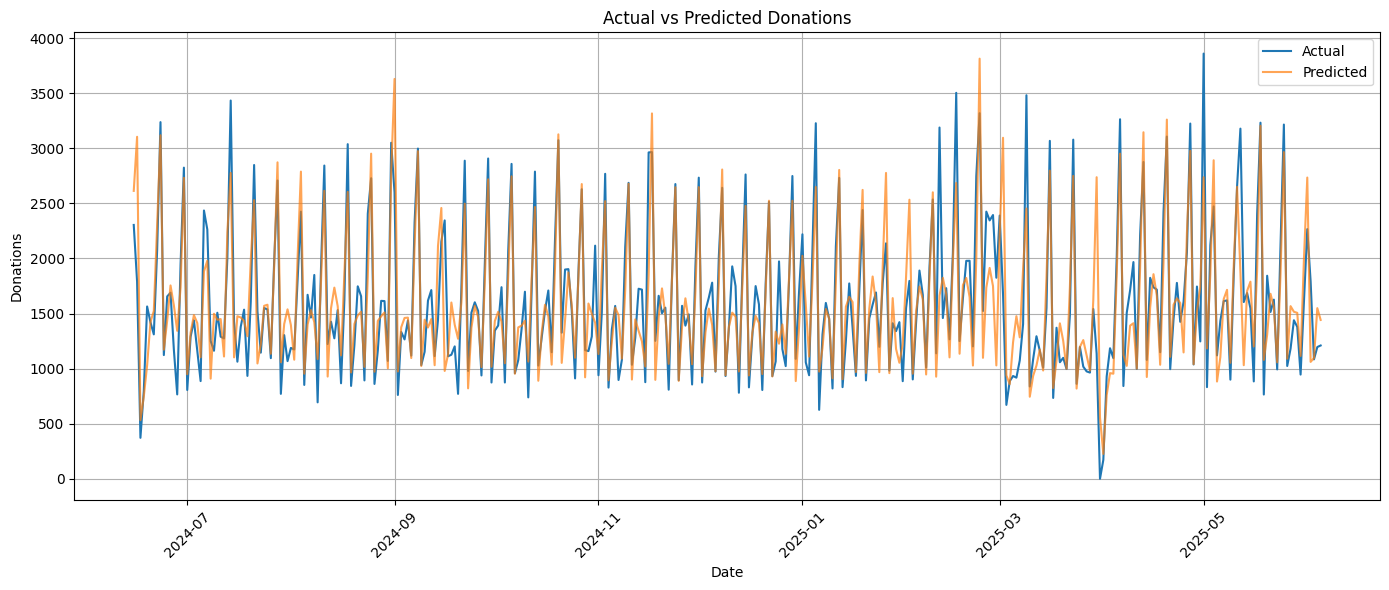

In [20]:
pred_df = pl.DataFrame({'y_true': y_test_scaled.flatten(), 'y_pred': np.round(y_pred).flatten()})

pred_df = pred_df.with_columns(
    (pl.col('y_true') - pl.col('y_pred')).alias('diff')
).with_columns(
    pl.Series("date", df_all[-pred_df.height:]["date"])
)

pred_df = pred_df.with_columns(
    (abs(pl.col('diff')).alias('abs_diff'))
)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pred_df["date"], pred_df["y_true"], label="Actual")
plt.plot(pred_df["date"], pred_df["y_pred"], label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Donations")
plt.xlabel("Date")
plt.ylabel("Donations")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
pred_df.sort(by='abs_diff', descending=True).head(10)

y_true,y_pred,diff,date,abs_diff
f64,f32,f64,date,f64
1136.0,2737.0,-1601.0,2025-03-30,1601.0
3188.0,1663.0,1525.0,2025-02-11,1525.0
1674.0,3095.0,-1421.0,2025-03-02,1421.0
2345.0,979.0,1366.0,2024-09-16,1366.0
1789.0,3104.0,-1315.0,2024-06-16,1315.0
3178.0,1878.0,1300.0,2025-05-12,1300.0
3859.0,2737.0,1122.0,2025-05-01,1122.0
2962.0,1848.0,1114.0,2024-11-16,1114.0
2599.0,3629.0,-1030.0,2024-09-01,1030.0


While all in all the model seems to be performing well, on certain days it still shows a bigger deviance:
- 2025-03-30: The day before Hari Raya Puasa, while not a holiday itself can lead to lower level of donations (preparations etc)
- 2025-02-11: Thaipusam, which is not a national holiday but observed in eight states. Incorporating this can be valuable in the future
- 2025-03-02: The first day of Ramadan, which also leads to lower actual donations than predicted
- 2024-09-01: The day after Merdeka Day, in the states of Kelantan and Terengganu this day itself is even a holiday

Some other days which should have been properly observed still showed some difference:
- 2024-09-16: Malaysia Day
- 2025-05-12: Wesak Day
- 2025-05-01: Labor Day

Based on this it might make sense to extend the low donation holidays to 1 day before/after the actual date.

In [22]:
# Saving the model
model.save(f"shared/model_{experiment_name}.keras")

## Comparison with simple benchmarks

### Comparison with mean value from the validation set

In [27]:
# Comparison with mean value from validation set
mean_val = y_scaler.inverse_transform(y_val.reshape(-1, 1)).mean()

mean_pred = np.full_like(y_test_scaled, mean_val)
mean_absolute_error(y_test_scaled, mean_pred)

526.6071462578556

### Comparison with rolling average

In [42]:
# Concatenate y_train, y_val, and y_test for easy indexing
y_all = np.concatenate([y_val, y_test])

# Indices for the start of y_test in y_all
test_start_idx = len(y_val)

# Rolling average prediction for y_test
rolling_preds = []
for i in range(test_start_idx, test_start_idx + len(y_test)):
    # Take the previous 7 days
    prev_7 = y_all[i-constants.WINDOW_SIZE:i]
    rolling_preds.append(prev_7.mean())

rolling_preds = np.array(rolling_preds)

mean_absolute_error(y_test, 
                    y_scaler.inverse_transform(rolling_preds[-len(y_test):].reshape(-1, 1))
)

1612.5570317883635

We could confirm that using the model is meaningfully better in terms of performance over simple benchmarks.